In [1]:
# PEP8
# %load_ext pycodestyle_magic
# %pycodestyle_off

In [2]:
# Verbose
from functions import *
import warnings
import timeit
from tqdm import tqdm

# Haversine
from haversine import haversine, Unit

# Random
import random

# Pandas
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Scipy
import scipy

# Numpy
import numpy as np

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [3]:
# matplotlib
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns
sns.set()

In [4]:
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Cluster
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

## 1.0 Initialisation

In [5]:
# Chargement des données
data = pd.read_csv(
    "dataset_simulation.csv").drop(
    ['Unnamed: 0',],axis=1)

In [6]:
# Suppression des doublons
data.drop_duplicates(subset=['customer_id'],
                     inplace=True)

In [7]:
# Nombre d'indexs
data.shape[0]

95831

In [8]:
# Coordonnées de l'entrepôt
olist = (-25.43045, -49.29207)

# Modification au format datetime
data['order_purchase_timestamp'] = data[
    'order_purchase_timestamp'].astype('datetime64')

# Modification au format datetime
data['order_estimated_delivery_date'] = data[
    'order_estimated_delivery_date'].astype('datetime64')

# Modification au format datetime
data['order_delivered_customer_date'] = pd.to_datetime(
    data['order_delivered_customer_date'],
    errors='coerce')

## Fonctions de Feature Engineering

In [9]:
def FeatureEngineering(data):
    
    '''
    Fonction permettant de refaire un feature
    engineering sur mesure pour tout DataFrame en input
    '''
    
    # Création d'un dataframe vide
    final_data = pd.DataFrame()
    
    # last_day_purchase
    final_data['last_day_purchase'] = (
        data.order_purchase_timestamp.max()
        - data.groupby('customer_unique_id')[
            'order_purchase_timestamp'].max()).apply(
        lambda x: x.days)
    
    # mean_delay
    final_data['mean_delay'] = (
        data.groupby('customer_unique_id')[
            'order_estimated_delivery_date'].mean()
        - data.groupby('customer_unique_id')[
            'order_delivered_customer_date'].mean()).apply(
        lambda x: x.days)
    
    # warehouse_distance
    final_data['warehouse_distance'] = data.groupby(
        'customer_unique_id')[
        ['geolocation_lat','geolocation_lng']
    ].mean().apply(
        lambda x: haversine(
            (x['geolocation_lat'],
             x['geolocation_lng']),
             olist),
        axis=1)
    
    # command_nb
    final_data['command_nb'] = data.groupby(
        ['customer_unique_id']
    )['customer_unique_id'].count()
    
    # mean_basket
    final_data['mean_basket'] = data.groupby(
        ['customer_unique_id','order_id'])[
        'price'].mean().groupby(
        ['customer_unique_id']).mean()
    
    # max_product_price
    final_data['max_product_price'] = data.groupby(
        ['customer_unique_id'])['price'].max()
    
    # total_spent
    final_data['total_spent'] = data.groupby(
        ['customer_unique_id'])['price'].sum()
    
    # mean_review_note
    final_data['mean_review_note'] = data.groupby(
        ['customer_unique_id'])['review_score'].mean()
    
    # Traitement des valeurs abérrantes
    final_data = final_data[final_data['mean_delay'] < 1000]
    final_data = final_data[final_data['mean_delay'] > 0]
    
    return final_data

# Création d'un dataframe

## 2.0 Mise en place d'une temporalité

In [10]:
print("Date du premier achat", data.order_purchase_timestamp.min())
print("Date du dernier achat", data.order_purchase_timestamp.max())

Date du premier achat 2016-10-03 09:44:50
Date du dernier achat 2018-08-29 15:00:37


In [12]:
print("Nombre de jours total sur la période :", (data.order_purchase_timestamp.max() - data.order_purchase_timestamp.min()).days)

Nombre de jours total sur la période : 695


## 3.0 Calcul du ARI

In [56]:
def DataDated(data, days):
    '''Permet de créer un Dataframe ne contenant 
    que les clients ayant acheté sur une période définie'''
    return data[
        data.order_purchase_timestamp <= (data.order_purchase_timestamp.min()
                                          + DateOffset(days=150 
                                                       + days))]

In [57]:
# Permet de fixer les aléatoires 
# afin de comparer plus facilement les résultats
random.seed(10)

In [58]:
# Initialisation du modèle à T0 (pour J=150)
F0 = FeatureEngineering(DataDated(data, 0))
old_transformer = MinMaxScaler().fit(F0)
F0_scaled = old_transformer.transform(F0)
M0 = KMeans(n_clusters=4).fit(F0_scaled)

Boucle créant un nouveau DataFrame et son modèle associé afin de comparer l'efficacité de l'ancien modèle face à un nouveau

In [59]:
# Liste qui contiendra les résultats de l'ARI
# et son jour associé
ARI_score = []

for i in tqdm(range(0, 365, 7)):
    Fi = FeatureEngineering(DataDated(data, i))
    Fi = Fi[Fi.index.isin(F0.index.tolist())]
    new_transformer = MinMaxScaler().fit(Fi)
    
    Fi_std_old = old_transformer.transform(Fi)
    clusters_old = M0.predict(Fi_std_old)
    
    Fi_std_new = new_transformer.transform(Fi)
    Mi = KMeans(n_clusters=4).fit(Fi_std_new)
    clusters_new = Mi.predict(Fi_std_new)
    
    ARI = adjusted_rand_score(clusters_old, clusters_new)
    ARI_score.append([i,
                      ARI])

100%|███████████████████████████████████████████| 53/53 [00:53<00:00,  1.01s/it]


In [60]:
# Création d'un DataFrame contenant les résultats de l'ARI
ARI_data_score = pd.DataFrame(
    ARI_score, columns=[
        "periode", "ARI"])
ARI_data_score[
    'weeks'] = ARI_data_score.reset_index()[
    'index']+1

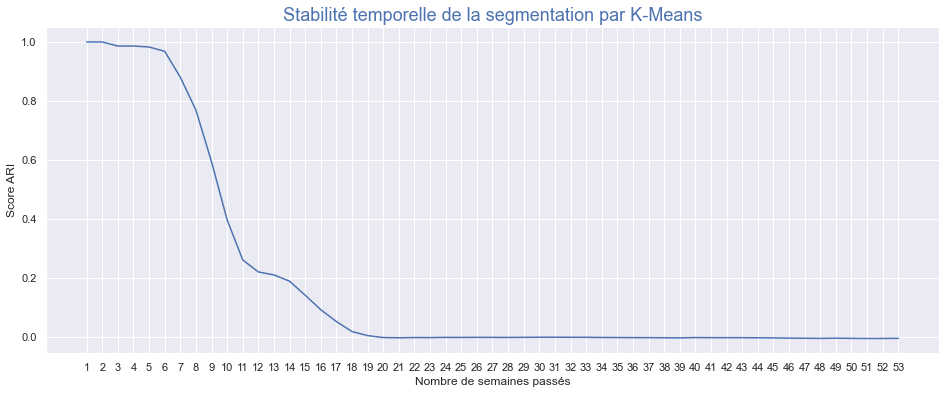

In [61]:
# Affichage de la stabilité temporelle sur 1 an
fig = plt.figure(figsize=(16,
                          6))
sns.lineplot(data=ARI_data_score,
             x="weeks",
             y="ARI")

plt.xlabel("Nombre de semaines passés")
plt.xticks(ARI_data_score.weeks)
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

**Note:** *On peut considérer que l'ARI devient trop bas en dessous de 0.8, soit à la 8ème semaine (46 jours).*

## 4.0 Test sur la période la plus récente

In [67]:
def DataDated(data, days):
    '''Permet de créer un Dataframe ne contenant 
    que les clients ayant acheté sur une période définie'''
    return data[
        data.order_purchase_timestamp <= (data.order_purchase_timestamp.min()
                                          + DateOffset(days=695-46 
                                                       + days))]

Boucle créant un nouveau DataFrame et son modèle associé afin de comparer l'efficacité de l'ancien modèle face à un nouveau

In [68]:
# Liste qui contiendra les résultats de l'ARI
# et son jour associé
ARI_score = []

for i in range(0, 46, 7):
    Fi = FeatureEngineering(DataDated(data, i))
    Fi = Fi[Fi.index.isin(F0.index.tolist())]
    new_transformer = MinMaxScaler().fit(Fi)
    
    Fi_std_old = old_transformer.transform(Fi)
    clusters_old = M0.predict(Fi_std_old)
    
    Fi_std_new = new_transformer.transform(Fi)
    Mi = KMeans(n_clusters=4).fit(Fi_std_new)
    clusters_new = Mi.predict(Fi_std_new)
    
    ARI = adjusted_rand_score(clusters_old, clusters_new)
    ARI_score.append([i,
                      ARI])

In [69]:
# Création d'un DataFrame contenant les résultats de l'ARI
ARI_data_score = pd.DataFrame(ARI_score, columns=["periode", "ARI"])
ARI_data_score['weeks'] = ARI_data_score.reset_index()['index']+1

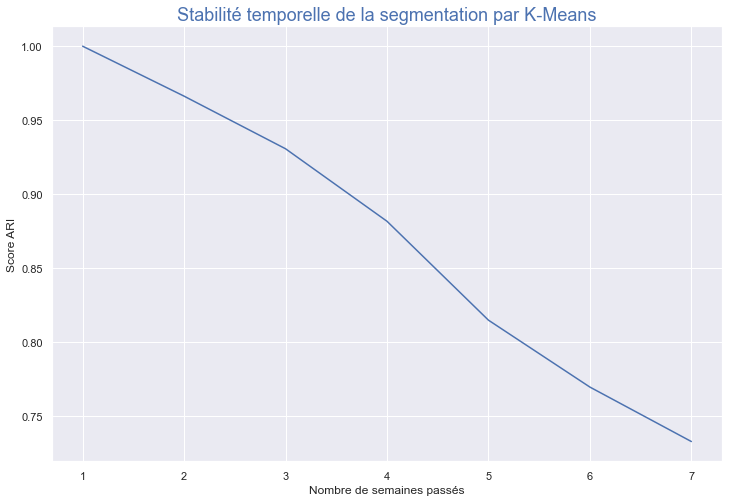

In [70]:
# Affichage de la stabilité temporelle sur les 46 derniers jours
fig = plt.figure(figsize=(12,
                          8))
sns.lineplot(data=ARI_data_score,
             x="weeks",
             y="ARI")

plt.xlabel("Nombre de semaines passés")
plt.xticks(ARI_data_score.weeks)
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

**Note:** *On voit que les résultats ne changent pas drastiquement (37 jours au lieu de 46).*